Prepare the data
Check the data and its stationarity

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

C:\Users\ROG\AppData\Local\Temp\ipykernel_8068\153819500.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
dateparse = lambda dates: pd.to_datetime(dates, format='%Y-%m-%d')
stock_data = pd.read_excel("C:/Users/ROG/Desktop/so this is the sadness/MINI Project/Data/candlestick_chart_data.xlsx", index_col='Date', parse_dates=['Date'])
pd.set_option('display.max_columns', None)
print(stock_data)

            Opening price  Highest price  Lowest price  Closing price  \
Date                                                                    
2025-01-02            267            303           243            288   
2025-01-03            281            317           270            291   
2025-01-06            278            346           276            327   
2025-01-07            336            388           317            369   
2025-01-08            365            374           303            311   
...                   ...            ...           ...            ...   
2025-06-25             96            114            93            104   
2025-06-26            113            114            94            111   
2025-06-27            106            113            93            111   
2025-06-30            103            113            93            110   
2025-07-01             94            114            93            107   

            Trading volume  Turnover  
Date       

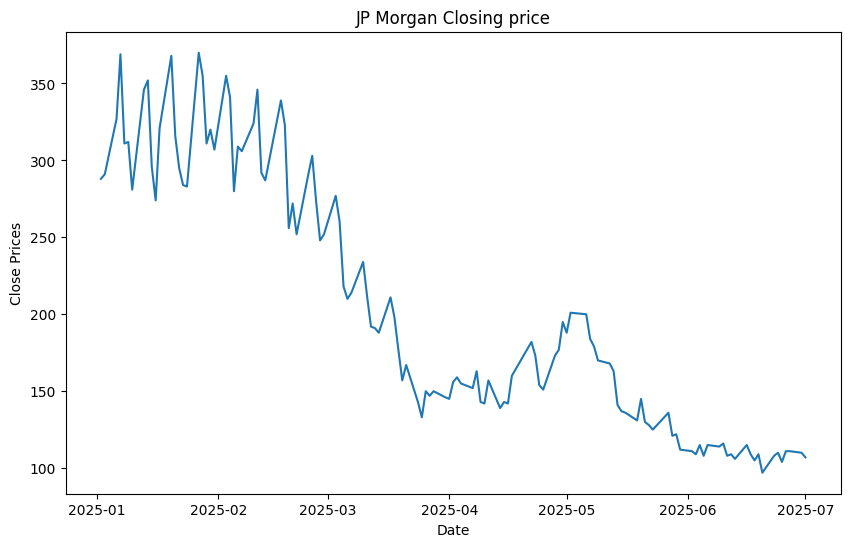

In [3]:
#Visualize the per day closing price of the stock.
plt.figure(figsize=(10,6))
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Closing price'])
plt.title('JP Morgan Closing price')
plt.show()


<Axes: ylabel='Density'>

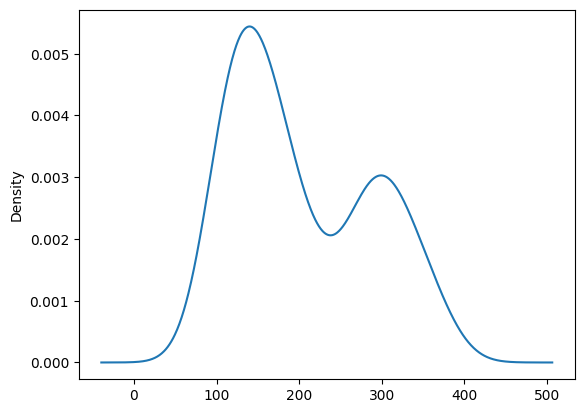

In [4]:
# Distribution of the dataset
df_close=stock_data['Closing price']
df_close.plot(kind='kde')

In [5]:
#Using the ADF test to check if a series is stationary or not because time series analysis only works with stationary data
def test_stationarity(timeseries):
    print("Results for dickey fuller test")
    results=adfuller(timeseries, autolag='AIC')
    output=pd.Series(results[0:4], index=['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in results[4].items():
        output['critical value (%s)'%key] =values
    print(output)

In [6]:
test_stationarity(df_close)

Results for dickey fuller test
Test Statistics                 -0.922090
p-value                          0.780611
No. of lags used                10.000000
Number of observations used    114.000000
critical value (1%)             -3.489058
critical value (5%)             -2.887246
critical value (10%)            -2.580481
dtype: float64


Text(0.5, 1.0, '2 order differencing')

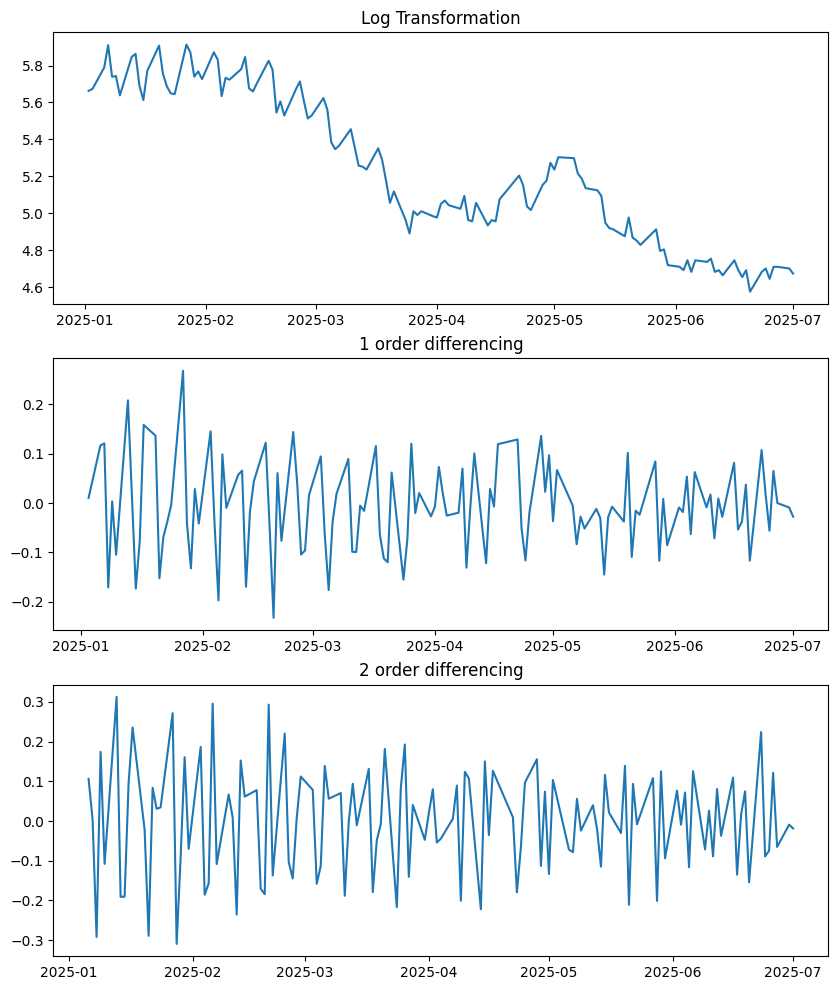

In [7]:
# # Nomalization
# avg, dev=df_close.mean(),df_close.std()
# df_nomal=(df_close-avg)/dev
# df_nomal.plot()
# # Log transformation
df_log=np.log(df_close)
fig,axe = plt.subplots(3,1, figsize=(10,12))
axe[0].plot(df_log)
axe[0].set_title('Log Transformation')
# Take first difference to remove the trend
df_diff=df_log.diff().dropna()
axe[1].plot(df_diff)
axe[1].set_title('1 order differencing')

df_diff_2=df_diff.diff().dropna()
axe[2].plot(df_diff_2)
axe[2].set_title('2 order differencing')

In [8]:
test_stationarity(df_diff)

Results for dickey fuller test
Test Statistics                 -3.701667
p-value                          0.004090
No. of lags used                 5.000000
Number of observations used    118.000000
critical value (1%)             -3.487022
critical value (5%)             -2.886363
critical value (10%)            -2.580009
dtype: float64


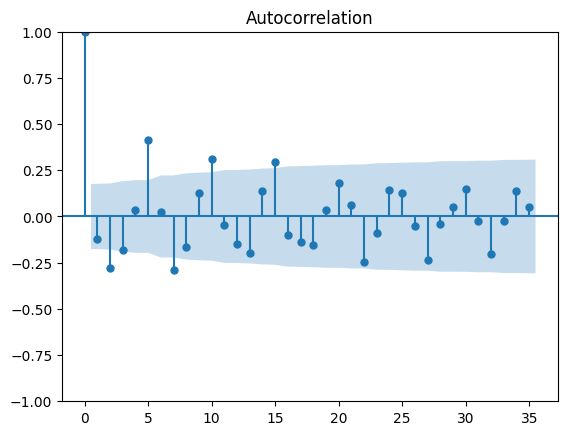

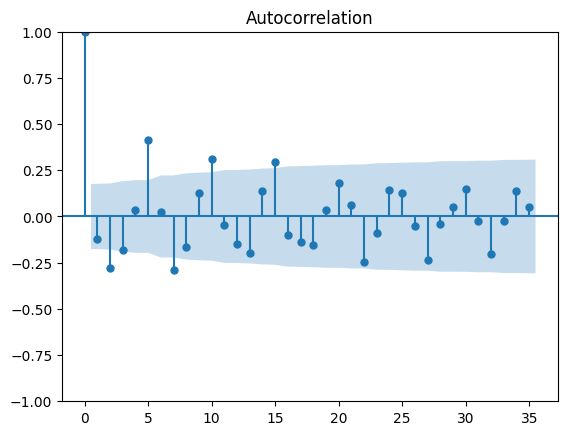

In [9]:
n_lags=35
plot_acf(df_diff,lags=n_lags, alpha=0.05)

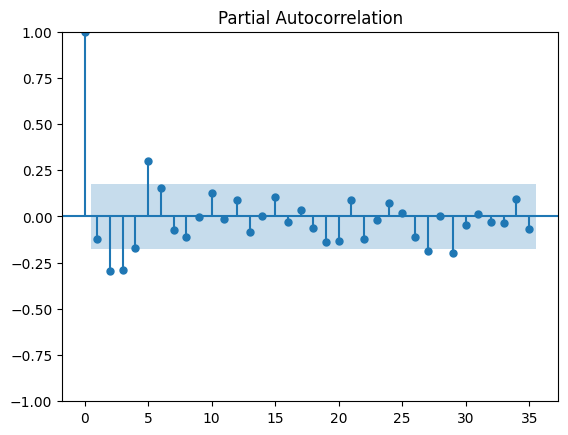

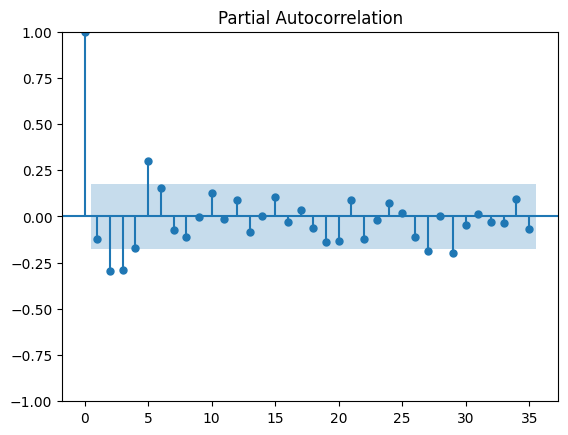

In [16]:
plot_pacf(df_diff,lags=n_lags)

Split data

In [ ]:
def train_test_split(df,size=0.9):
    train_data, test_data=df[:int(len(df)*size)], df[int(len(df)*size):]
    plt.figure(figsize=(10,6))
    plt.grid(True)
    plt.xlabel('Dates')
    plt.ylabel('Closing Prices')
    plt.plot(df,'green', label='Train data')
    plt.plot(test_data, 'blue', label='Test data')
    plt.legend()
    return train_data, test_data

DatetimeIndex(['2025-01-02', '2025-01-03', '2025-01-06', '2025-01-07',
               '2025-01-08', '2025-01-09', '2025-01-10', '2025-01-13',
               '2025-01-14', '2025-01-15',
               ...
               '2025-06-18', '2025-06-19', '2025-06-20', '2025-06-23',
               '2025-06-24', '2025-06-25', '2025-06-26', '2025-06-27',
               '2025-06-30', '2025-07-01'],
              dtype='datetime64[ns]', name='Date', length=125, freq=None)


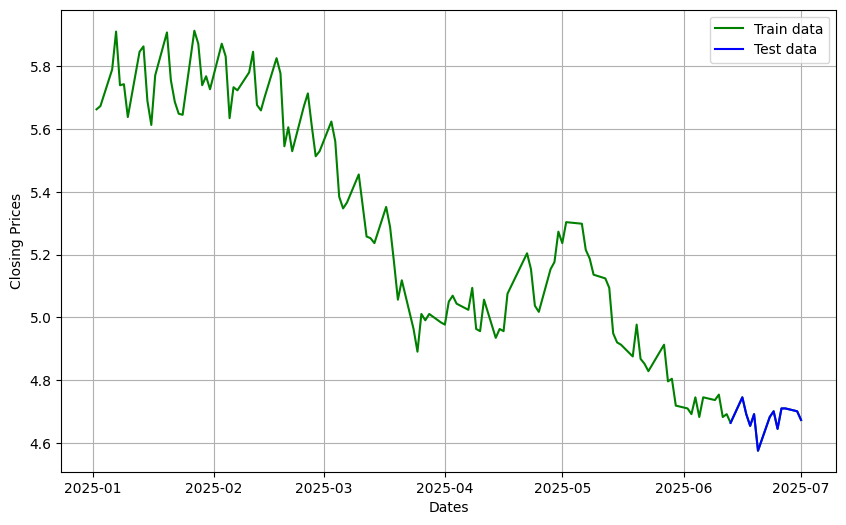

In [13]:
print(df_log.index)
train_data,test_data=train_test_split(df_log, 0.9)

In [14]:
train_data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-06-06    4.744932
2025-06-09    4.736198
2025-06-10    4.753590
2025-06-11    4.682131
2025-06-12    4.691348
Name: Closing price, Length: 112, dtype: float64

In [15]:
test_data

Date
2025-06-13    4.663439
2025-06-16    4.744932
2025-06-17    4.691348
2025-06-18    4.653960
2025-06-19    4.691348
2025-06-20    4.574711
2025-06-23    4.682131
2025-06-24    4.700480
2025-06-25    4.644391
2025-06-26    4.709530
2025-06-27    4.709530
2025-06-30    4.700480
2025-07-01    4.672829
Name: Closing price, dtype: float64

Model Selection

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autore

AIC for ARIMA(2,1,2):-237.2028681158342
AIC for ARIMA(2,1,11):-226.01875855518313
AIC for ARIMA(3,1,2):-241.31898181572873
AIC for ARIMA(3,1,11):-229.6538483774081
AIC for ARIMA(11,1,2):-230.19450535122968
AIC for ARIMA(11,1,11):-217.81049913847426


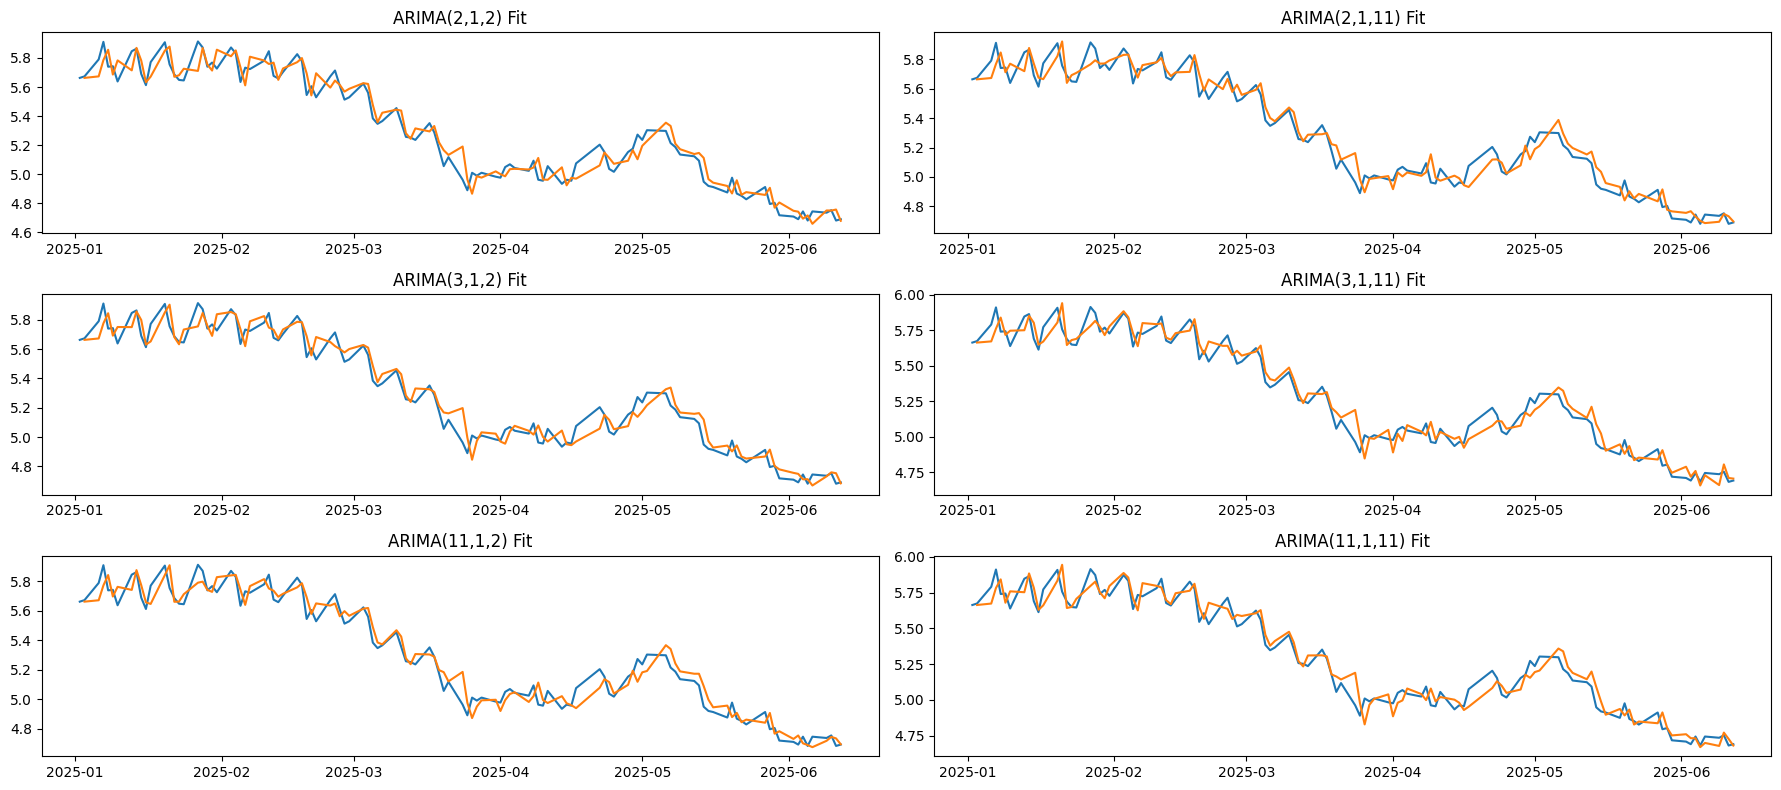

In [17]:
# model selection
ar_orders=[2,3,11]
ma_orders=[2,11]
fitted_model_dict={}
AIC_dict={}
fig,axes=plt.subplots(len(ar_orders),len(ma_orders),figsize=(18,8))
for idx, ar_order in enumerate(ar_orders):
    for idy, ma_order in enumerate(ma_orders):
        # create ARIMA model
        model=ARIMA(train_data, order=(ar_order,1,ma_order))
        model_fit = model.fit()
        fitted_model_dict[ar_order,ma_order]=model_fit
        AIC_dict[ar_order,ma_order]=fitted_model_dict[ar_order,ma_order].aic
        ax = axes[idx, idy]
        ax.set_title('ARIMA(%s,1,%s) Fit'%(ar_order,ma_order))
        ax.plot(train_data)
        ax.plot(model_fit.fittedvalues[1:])
plt.tight_layout()
for ar_order in ar_orders:
    for ma_order in ma_orders:
        print('AIC for ARIMA(%s,1,%s):%s'%(ar_order,ma_order,AIC_dict[ar_order,ma_order]))

In [18]:
# Sort the dictionary by value and return the first key-value pair
min_key, min_val = sorted(AIC_dict.items(), key=lambda x: x[1])[0]
print("The ARIMA model with the lowest AIC is: (%s,1,%s)"%(min_key[0],min_key[1]))

The ARIMA model with the lowest AIC is: (3,1,2)


Type Markdown and $$Latex:\alpha^{2}$$

Figure(1500x800)


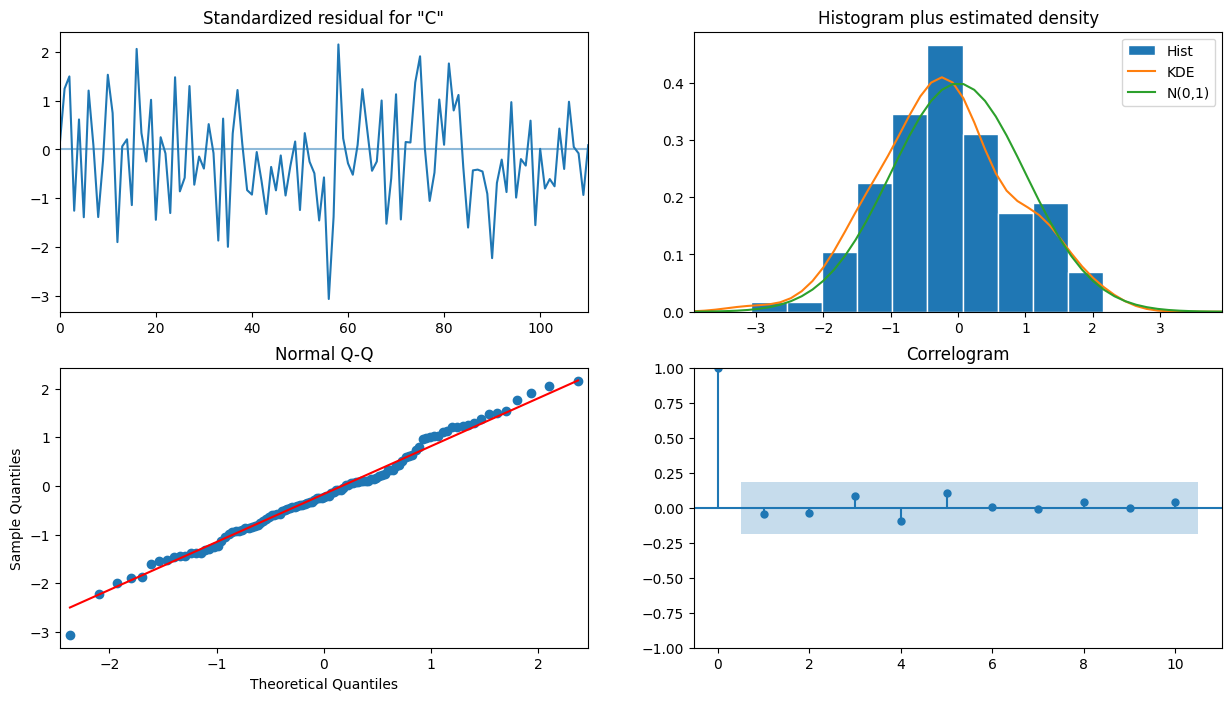

In [19]:
print(fitted_model_dict[min_key[0],min_key[1]].plot_diagnostics(figsize=(15,8)))

Test the data

Date
2025-01-02    5.662960
2025-01-03    5.673323
2025-01-06    5.789960
2025-01-07    5.910797
2025-01-08    5.739793
                ...   
2025-06-06    4.744932
2025-06-09    4.736198
2025-06-10    4.753590
2025-06-11    4.682131
2025-06-12    4.691348
Name: Closing price, Length: 112, dtype: float64
Date
2025-01-02    0.000000
2025-01-03    5.662960
2025-01-06    5.672521
2025-01-07    5.775465
2025-01-08    5.844472
                ...   
2025-06-06    4.669894
2025-06-09    4.732287
2025-06-10    4.759641
2025-06-11    4.753603
2025-06-12    4.684603
Length: 112, dtype: float64


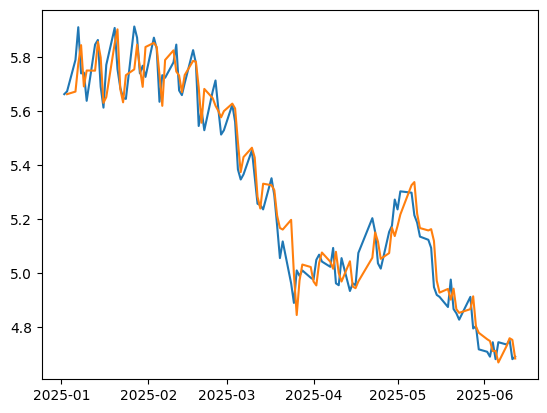

In [20]:
model_fit=fitted_model_dict[min_key[0],min_key[1]]
#model_fit=fitted_model_dict[3,2]
#get the predictions and residuals
predictions=model_fit.fittedvalues
# residuals = test_data - predictions
print(train_data)
print(predictions)
plt.plot(train_data)
plt.plot(predictions[1:])

In [21]:
pre_test=model_fit.forecast(steps=len(test_data))
# lower_series = pd.Series(conf[:, 0], index=test_data.index)
# upper_series = pd.Series(conf[:, 1], index=test_data.index)
print(pre_test)

112    4.685289
113    4.702313
114    4.709190
115    4.699132
116    4.685912
117    4.688389
118    4.702617
119    4.708352
120    4.697760
121    4.686122
122    4.689793
123    4.703230
124    4.707330
Name: predicted_mean, dtype: float64


C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [22]:
fc_series = pd.Series(np.array(pre_test), index=test_data.index)
fc_series

Date
2025-06-13    4.685289
2025-06-16    4.702313
2025-06-17    4.709190
2025-06-18    4.699132
2025-06-19    4.685912
2025-06-20    4.688389
2025-06-23    4.702617
2025-06-24    4.708352
2025-06-25    4.697760
2025-06-26    4.686122
2025-06-27    4.689793
2025-06-30    4.703230
2025-07-01    4.707330
dtype: float64

<Axes: xlabel='Date'>

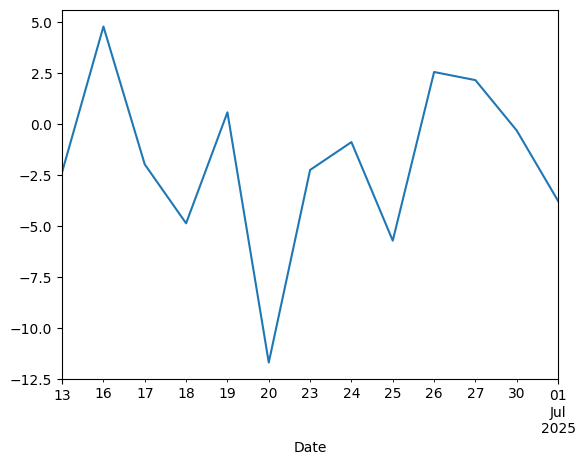

In [23]:
residuals=np.exp(test_data)-np.exp(fc_series)
residuals.plot()

RMSE: 4.440857261760172
MAPE: 0.032137819982394095


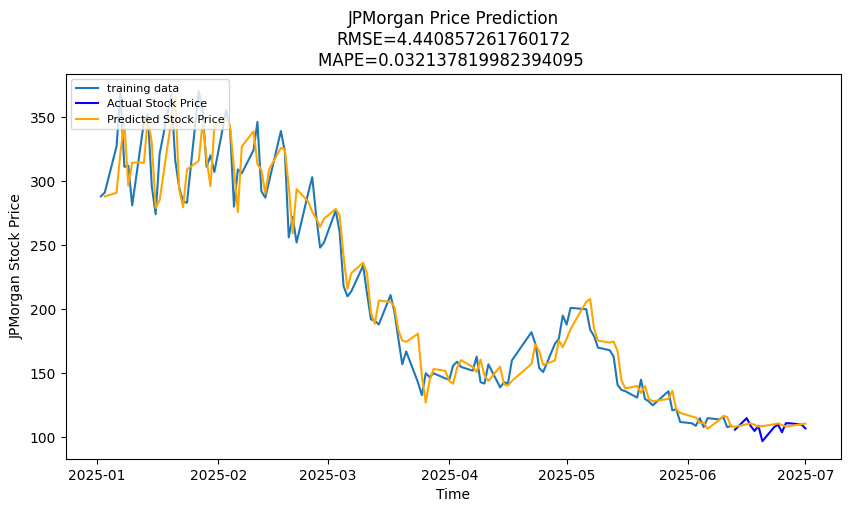

In [26]:
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
concat_df=[predictions[1:],fc_series]
pred_df=pd.concat(concat_df)
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(pred_df), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc_series)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('JPMorgan Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

Using Auto-ARIMA Model

Rolling Forecasting Origin

In [27]:
# create the model
from datetime import timedelta
predictions_rolling=pd.Series()
for end_date in test_data.index:
    train_data=df_log[:end_date-timedelta(days=1)]
    model=ARIMA(train_data, order=(min_key[0],1,min_key[1]))
    model_fit=model.fit()
    pred=model_fit.forecast(steps=1)
    predictions_rolling.loc[end_date]=pred.values[0]
print(model_fit.summary)

C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autore

<bound method SARIMAXResults.summary of <statsmodels.tsa.arima.model.ARIMAResults object at 0x000002661446DB50>>


C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(
C:\Users\ROG\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequ

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


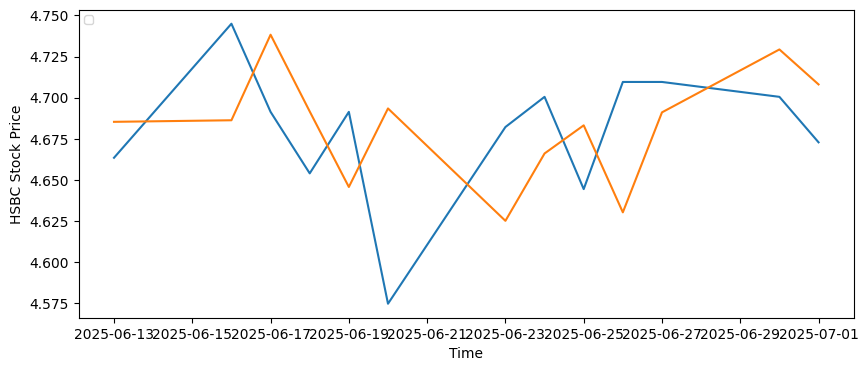

In [28]:
# draw the prediction plot
plt.figure(figsize=(10,4))
plt.plot(test_data)
plt.plot(predictions_rolling)

plt.xlabel('Time')
plt.ylabel('HSBC Stock Price')
plt.legend(loc='upper left', fontsize=8)

In [29]:
residuals_rolling=np.exp(test_data)-np.exp(predictions_rolling) # get the residuals
print(residuals_rolling)
print(predictions_rolling)

Date
2025-06-13    -2.341528
2025-06-16     6.555187
2025-06-17    -5.234442
2025-06-18    -4.027545
2025-06-19     4.865385
2025-06-20   -12.225938
2025-06-23     5.987200
2025-06-24     3.722711
2025-06-25    -4.110664
2025-06-26     8.459149
2025-06-27     2.032532
2025-06-30    -3.215326
2025-07-01    -3.833363
dtype: float64
2025-06-13    4.685289
2025-06-16    4.686241
2025-06-17    4.738253
2025-06-18    4.691601
2025-06-19    4.645684
2025-06-20    4.693419
2025-06-23    4.625098
2025-06-24    4.666052
2025-06-25    4.683155
2025-06-26    4.630261
2025-06-27    4.691049
2025-06-30    4.729292
2025-07-01    4.708028
dtype: float64


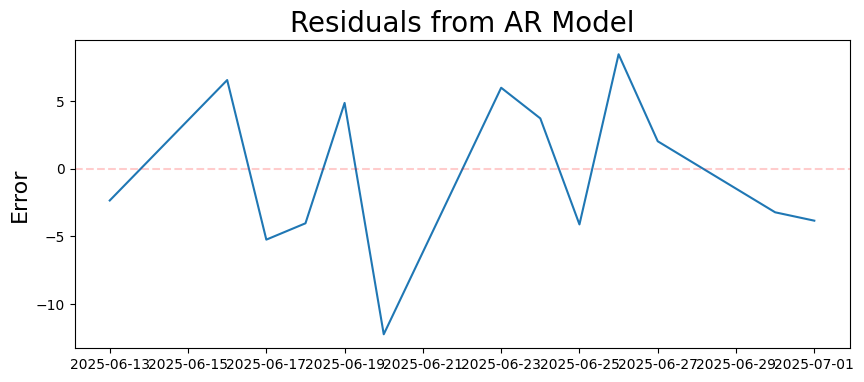

In [30]:
plt.figure(figsize=(10,4))
plt.plot(residuals_rolling)
plt.title('Residuals from AR Model', fontsize=20)
plt.ylabel('Error', fontsize=16)
plt.axhline(0,color='r',linestyle='--',alpha=0.2)

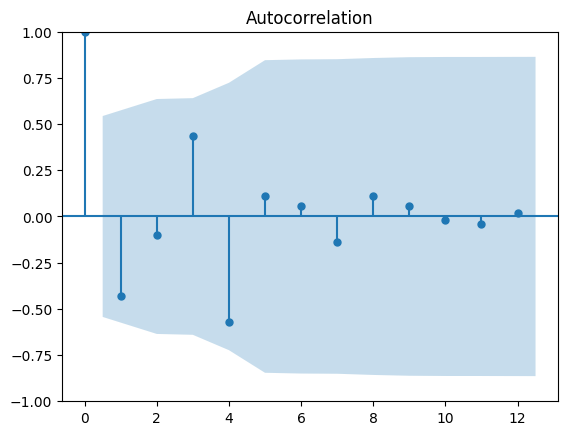

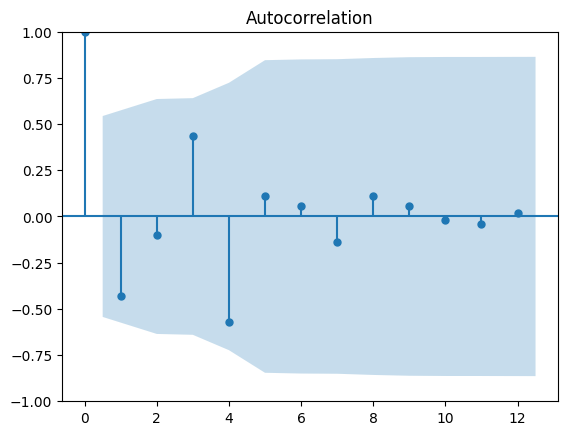

In [31]:
plot_acf(residuals_rolling,lags=12)

In [32]:
print('Mean Absolute Percent Error:',round(np.mean(abs(residuals_rolling/np.exp(test_data))),4))
print('Root Mean Squared Error:',np.sqrt(np.mean(residuals_rolling**2)))

Mean Absolute Percent Error: 0.048
Root Mean Squared Error: 5.76823748489609


RMSE: 5.76823748489609
MAPE: 0.04804075606891222


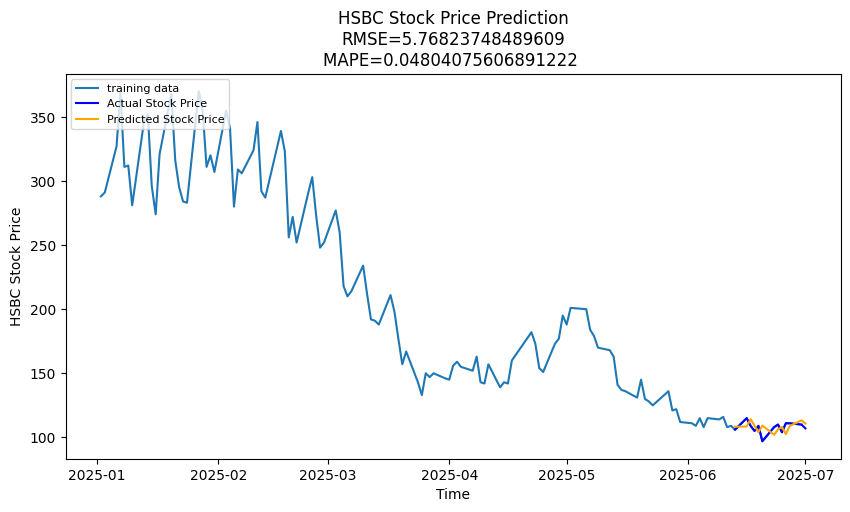

In [34]:
plt.figure(figsize=(10,5), dpi=100)
plt.plot(np.exp(train_data), label='training data')
plt.plot(np.exp(test_data), color = 'blue', label='Actual Stock Price')
plt.plot(np.exp(predictions_rolling), color = 'orange',label='Predicted Stock Price')
#plt.fillbetween(test_data.index, lower_series, upper_series, color='k', alpha=.15)
rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(predictions_rolling)))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(residuals_rolling)/np.abs(np.exp(test_data)))
print('MAPE: '+str(mape))
plt.title('HSBC Stock Price Prediction\nRMSE=%s\nMAPE=%s '%(str(rmse),str(mape)))
plt.xlabel('Time')
plt.ylabel('HSBC Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()